# Imports and definitions

In [1]:
import os

from IPython.display import clear_output

import numpy as np
import time
import scipy.io
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow.keras.backend as K

import tensorflow as tf

import random
import itertools

import pickle

import numbers
from numpy.lib.stride_tricks import as_strided

from keras.engine.input_layer import Input

from google.colab import drive
drive.mount('/content/gdrive')
tf.enable_eager_execution()

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
tf.version.VERSION

'1.15.0'

In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

In [0]:
import utils
import adversarial
import importlib

importlib.reload(utils)
importlib.reload(adversarial)

<module 'adversarial' from '/content/gdrive/My Drive/Colab Notebooks/adversarial.py'>

In [0]:
scores = utils.read_scores("/content/gdrive/My Drive/tid2013/mos.txt").astype(np.float64)
ref_images = utils.read_images("/content/gdrive/My Drive/tid2013/reference_images")
ref_images = ref_images.astype(np.float64)

['I01.BMP', 'I02.BMP', 'I03.BMP', 'I04.BMP', 'I05.BMP', 'I06.BMP', 'I07.BMP', 'I08.BMP', 'I09.BMP', 'I10.BMP', 'I11.BMP', 'I12.BMP', 'I13.BMP', 'I14.BMP', 'I15.BMP', 'I16.BMP', 'I17.BMP', 'I18.BMP', 'I19.BMP', 'I20.BMP', 'I21.BMP', 'I22.BMP', 'I23.BMP', 'I24.BMP', 'i25.bmp']
['1600.png', 'aerial_city.png', 'boston.png', 'bridge.png', 'butter_flower.png', 'cactus.png', 'child_swimming.png', 'couple.png', 'elk.png', 'family.png', 'fisher.png', 'foxy.png', 'geckos.png', 'lady_liberty.png', 'lake.png', 'log_seaside.png', 'monument.png', 'native_american.png', 'redwood.png', 'roping.png', 'rushmore.png', 'shroom.png', 'snow_leaves.png', 'sunset_sparrow.png', 'sunsetcolor.png', 'swarm.png', 'trolley.png', 'turtle.png', 'veggies.png', 'woman.png']


In [0]:
def key_fun(x):
  splitted = x.split("_")
  return 10000 * int(splitted[0][1:]) + 100 * int(splitted[1]) + int(splitted[2][:-4])
image_names = sorted(os.listdir("/content/gdrive/My Drive/tid2013/distorted_images"), key=key_fun)

In [0]:
class NoiseLayer(tf.keras.layers.Layer):
    def __init__(self,mean):
        super(NoiseLayer, self).__init__()
        self.mean = mean

    def get_config(self):
        return {"mean": self.mean}

    def call(self, input):
        return input + tf.random.uniform(tf.shape(input), minval=-0.5 * self.mean, maxval=0.5*self.mean)

def make_generator(noise_magnitude=0):
  image_in = tf.keras.Input(shape=(384,512,3), dtype=tf.float32)
  s1 = tf.keras.layers.Conv2D(32, (9,9), strides=(4,4), padding='same', activation='relu', dtype=tf.float32, name="s1")(image_in)
  s2 = tf.keras.layers.Conv2D(32, (5,5), strides=(2,2), padding='same', activation='relu', dtype=tf.float32, name="s2")(s1)
  s_enc = tf.keras.layers.Conv2D(32, (5,5), strides=(2,2), padding='same', activation='relu', dtype=tf.float32, name="s_enc")(s2)

  if noise_magnitude > 0:
    s_enc = NoiseLayer(noise_magnitude)(s_enc)

  l_dec = tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', activation='relu', dtype=tf.float32, name="s_dec")
  l3 = tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', activation='relu', dtype=tf.float32, name="s3")
  l_out = tf.keras.layers.Conv2DTranspose(3, (9, 9), strides=(4, 4), padding='same', activation='relu', dtype=tf.float32, name="s_out")
  s_dec = l_dec(s_enc)
  s3 = l3(s_dec)
  s_out = l_out(s3)

  if noise_magnitude > 0:
    enc_in = tf.keras.Input(shape=(24,32,32), dtype=tf.float32)
    s_dec_e = l_dec(enc_in)
    s3_e = l3(s_dec_e)
    s_out_e = l_out(s3_e)
  if noise_magnitude <= 0:
    return tf.keras.Model(inputs=image_in, outputs=s_out)
  else:
    return (tf.keras.Model(inputs=image_in, outputs=s_out), tf.keras.Model(inputs=image_in, outputs=s_enc), tf.keras.Model(inputs=enc_in, outputs=s_out_e))

# Training simple metric without tricks

In [0]:
# Defines a DIQaM architecture without sigmoid
im_input = tf.keras.Input(shape=(384, 512, 3), batch_size=10)
ref_input = tf.keras.Input(shape=(384, 512, 3), batch_size=10)

i_conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), padding='same', activation='relu')
i_conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same', activation='relu')
i_conv3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same', activation='relu')
i_conv4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2), padding='same', activation='relu')
i_conv5 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=(2,2), padding='same', activation='relu')
def extractor(image):
  conv1 = i_conv1(image)
  conv2 = i_conv2(conv1)
  conv3 = i_conv3(conv2)
  conv4 = i_conv4(conv3)
  conv5 = i_conv5(conv4)
  return tf.reshape(conv5, (-1, 192, 512))

patches_gen = tf.image.extract_patches(im_input, [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
patches_gen = tf.reshape(patches_gen, (-1, 32, 32, 3))
patches_ref = tf.image.extract_patches(ref_input, [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
patches_ref = tf.reshape(patches_ref, (-1, 32, 32, 3))
im_c = extractor(patches_gen)
ref_c = extractor(patches_ref)

subbed = tf.keras.layers.Subtract()([im_c, ref_c])
dense1 = tf.keras.layers.Dense(512, activation='relu')(subbed)
dense2 = tf.keras.layers.Dense(512, activation='relu')(dense1)
dense3 = tf.keras.layers.Dense(512, activation='relu')(dense2)
dense4 = tf.keras.layers.Dense(512, activation='relu')(dense3)
out = tf.keras.layers.Dense(1)(dense4)
out = tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x, 1))(out)

toy_model = tf.keras.Model(inputs=[im_input, ref_input], outputs=out)
toy_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0000025), loss=tf.keras.losses.MeanAbsoluteError())

In [0]:
toy_model.fit_generator(adversarial.create_fr_image_batch_full(ref_images, np.array(range(25)), scores,
                                                image_names, True, decode=False, n_images=1, n_patches=192),
                   steps_per_epoch=500, epochs=10)

Epoch 1/10
500/500 [==============================] - 24s 47ms/step - loss: 1.3666
Epoch 2/10
500/500 [==============================] - 25s 50ms/step - loss: 1.2043
Epoch 3/10
500/500 [==============================] - 25s 50ms/step - loss: 1.0517
Epoch 4/10
500/500 [==============================] - 23s 47ms/step - loss: 1.0389
Epoch 5/10
500/500 [==============================] - 22s 44ms/step - loss: 1.2111
Epoch 6/10
500/500 [==============================] - 22s 45ms/step - loss: 0.8520
Epoch 7/10
500/500 [==============================] - 24s 49ms/step - loss: 0.8713
Epoch 8/10
500/500 [==============================] - 24s 48ms/step - loss: 0.8395
Epoch 9/10
500/500 [==============================] - 22s 44ms/step - loss: 0.9825
Epoch 10/10
500/500 [==============================] - 22s 43ms/step - loss: 0.8165


In [0]:
toy_model.save("/content/gdrive/My Drive/Colab Notebooks/metric_simple.h5")

In [0]:
toy_model = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/metric_simple.h5")

# Training generator on simple metric

In [0]:
# Create an autoencoder and set its optimizer and loss function

#generators = make_generator(noise_magnitude=1.0)
#generator = generators[0]

generator = make_generator(0)
#generator = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/generator_wadiqam_r_1adv_l=5.h5")
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.000005)
generator_loss = tf.keras.losses.MeanSquaredError()

In [0]:
# Defines the various ways of optimizing the autoencoder: random/grid patch
# selection, full image as input, use of MSE and/or an IQA metric.
# This cell *must* run every time the variable "generator" is changed or
# tensorflow will refuse to run the training loops

ref_tensor = tf.convert_to_tensor(ref_images, tf.float32)
@tf.function
def gen_train_step_r(metric, _lambda=1):
  with tf.GradientTape() as gen_tape:
    generated_images = generator(tf.convert_to_tensor(ref_images, tf.float32))
    in_list = []
    in_list_ref = []
    for j in range(64):
      ul1 = np.random.randint(384-32)
      ul2 = np.random.randint(512-32)
      new_in = generated_images[:, ul1:ul1+32, ul2:ul2+32, :]
      in_list.append(new_in)
      new_in_ref = ref_tensor[:, ul1:ul1+32, ul2:ul2+32, :]
      in_list_ref.append(new_in_ref)

    input_tensor = tf.stack(in_list, 1)
    input_tensor_ref = tf.stack(in_list_ref, 1)
    scores_output = metric([tf.cast(input_tensor, tf.float32), tf.cast(input_tensor_ref, tf.float32)])
    gen_loss = -tf.math.reduce_mean(scores_output) + _lambda * generator_loss(generated_images, ref_images.astype(np.float32))

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))

@tf.function
def gen_train_step_error():
  with tf.GradientTape() as gen_tape:
    generated_images = generator(tf.convert_to_tensor(ref_images, tf.float32))
    gen_loss = generator_loss(generated_images, ref_images.astype(np.float32))

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def gen_train_step(metrics, _lambda=1):
  with tf.GradientTape() as gen_tape:
    generated_images = generator(tf.convert_to_tensor(ref_images))
    patches_gen = tf.image.extract_patches(generated_images, [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
    patches_gen = tf.reshape(patches_gen, (25, 192, 32, 32, 3))
    patches_ref = tf.image.extract_patches(ref_images, [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
    patches_ref = tf.reshape(patches_ref, (25, 192, 32, 32, 3))
    #patches_gen, patches_ref = extract_random_patches(generated_images, ref_images, 192, 32)
    scores_output = metrics[0]([tf.cast(patches_gen, tf.float32), tf.cast(patches_ref, tf.float32)])
    for i in range(len(metrics) - 1):
      scores_output += metrics[i+1]([tf.cast(patches_gen, tf.float32), tf.cast(patches_ref, tf.float32)])
    scores_output /= len(metrics)
    gen_loss = -tf.math.reduce_mean(scores_output) + _lambda * generator_loss(generated_images, ref_images.astype(np.float32))

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))

@tf.function
def gen_train_step_full(metrics, _lambda=1):
  with tf.GradientTape() as gen_tape:
    generated_images = generator(tf.convert_to_tensor(ref_images, tf.float32))
    scores_output = metrics[0]([tf.cast(generated_images, tf.float32), tf.cast(ref_images, tf.float32)])
    for i in range(len(metrics) - 1):
      scores_output += metrics[i+1]([tf.cast(generated_images, tf.float32), tf.cast(ref_images, tf.float32)])
    scores_output /= len(metrics)
    gen_loss = -tf.math.reduce_mean(scores_output) + _lambda * generator_loss(generated_images, ref_images.astype(np.float32))

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))

@tf.function
def gen_train_step_metric(metrics):
  with tf.GradientTape() as gen_tape:
    generated_images = generator(tf.convert_to_tensor(ref_images))
    patches_gen = tf.image.extract_patches(generated_images, [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
    patches_gen = tf.reshape(patches_gen, (25, 192, 32, 32, 3))
    patches_ref = tf.image.extract_patches(ref_images, [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
    patches_ref = tf.reshape(patches_ref, (25, 192, 32, 32, 3))
    #patches_gen, patches_ref = extract_random_patches(generated_images, ref_images, 192, 32)
    scores_output = metrics[0]([tf.cast(patches_gen, tf.float32), tf.cast(patches_ref, tf.float32)])
    for i in range(len(metrics) - 1):
      scores_output += metrics[i+1]([tf.cast(patches_gen, tf.float32), tf.cast(patches_ref, tf.float32)])
    scores_output /= len(metrics)
    gen_loss = -tf.math.reduce_mean(scores_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))

In [0]:
for i in range(250):
    if i % 50 == 0:
      print("Iteration: " + str(i))
    gen_train_step(toy_model, 0.01)

Iteration: 0
Iteration: 50
Iteration: 100
Iteration: 150
Iteration: 200


In [0]:
predictions = generator(tf.convert_to_tensor(ref_images, tf.float32))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


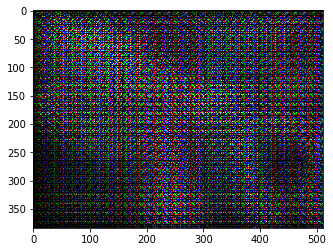

In [0]:
plt.imshow(predictions[2])

In [0]:
patches_gen = tf.image.extract_patches(np.array(predictions[22]).reshape((1,384,512,3)), [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
patches_gen = tf.reshape(patches_gen, (1, 192, 32, 32, 3))
patches_ref = tf.image.extract_patches(ref_images[22].reshape((1,384,512,3)), [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
patches_ref = tf.reshape(patches_ref, (1, 192, 32, 32, 3))
toy_model([tf.cast(patches_gen, tf.float32), tf.cast(patches_ref, tf.float32)])

NameError: ignored

# Training simple metric with sigmoid

In [0]:
# Defines a DIQaM architecture with a sigmoid to constrains the scores in [0,9]

im_input_trick = tf.keras.Input(shape=(384, 512 ,3), batch_size=10)
ref_input_trick = tf.keras.Input(shape=(384, 512 ,3), batch_size=10)

i_conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), padding='same', activation='relu')
i_conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same', activation='relu')
i_conv3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same', activation='relu')
i_conv4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2), padding='same', activation='relu')
i_conv5 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=(2,2), padding='same', activation='relu')
def extractor_trick(image):
  conv1 = (i_conv1(image))
  conv2 = (i_conv2(conv1))
  conv3 = (i_conv3(conv2))
  conv4 = (i_conv4(conv3))
  conv5 = (i_conv5(conv4))
  return tf.reshape(conv5, (-1, 192, 512))
  
def print_test(x):
  print(x)
  return extractor_trick(x)

patches_gen_trick = tf.image.extract_patches(im_input_trick, [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
patches_gen_trick = tf.reshape(patches_gen_trick, (-1, 32, 32, 3))
patches_ref_trick = tf.image.extract_patches(ref_input_trick, [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
patches_ref_trick = tf.reshape(patches_ref_trick, (-1, 32, 32, 3))
im_c_trick = extractor_trick(patches_gen_trick)
ref_c_trick = extractor_trick(patches_ref_trick)

subbed_trick = tf.keras.layers.Subtract()([im_c_trick, ref_c_trick])
dense1_trick = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(subbed_trick))
dense2_trick = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(dense1_trick))
dense3_trick = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(dense2_trick))
dense4_trick = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(dense3_trick))
out_trick = tf.keras.layers.Dense(1)(dense4_trick)
out_trick = tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x, 1))(out_trick)
out_trick = tf.keras.layers.Lambda(lambda x: tf.math.multiply(np.float32(9), tf.math.sigmoid(x)))(out_trick)

toy_model_trick = tf.keras.Model(inputs=[im_input_trick, ref_input_trick], outputs=out_trick)
toy_model_trick.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001), loss=tf.keras.losses.MeanAbsoluteError())

In [0]:
# Train/load a model

#toy_model_trick = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/metric_trick.h5")
toy_model_trick.fit_generator(adversarial.create_fr_image_batch_full(ref_images, np.array(range(25)), scores,
                                                image_names, True, decode=False, n_images=1, n_patches=192),
                   steps_per_epoch=500, epochs=200)

Epoch 1/200
500/500 [==============================] - 125s 251ms/step - loss: 4.3659
Epoch 2/200
500/500 [==============================] - 99s 199ms/step - loss: 1.8545
Epoch 3/200
500/500 [==============================] - 86s 172ms/step - loss: 1.4639
Epoch 4/200
500/500 [==============================] - 119s 238ms/step - loss: 1.5034
Epoch 5/200
500/500 [==============================] - 78s 157ms/step - loss: 1.4132
Epoch 6/200
500/500 [==============================] - 65s 131ms/step - loss: 1.2719
Epoch 7/200
500/500 [==============================] - 64s 128ms/step - loss: 1.2719
Epoch 8/200
500/500 [==============================] - 60s 120ms/step - loss: 1.4822
Epoch 9/200
500/500 [==============================] - 57s 113ms/step - loss: 1.3454
Epoch 10/200
500/500 [==============================] - 54s 109ms/step - loss: 1.3708
Epoch 11/200
500/500 [==============================] - 50s 100ms/step - loss: 1.4241
Epoch 12/200
500/500 [==============================] - 45s 9

In [0]:
toy_model_trick.save("/content/gdrive/My Drive/Colab Notebooks/metric_trick2.h5")

In [0]:
toy_model_trick1 = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/metric_trick1.h5")
toy_model_trick2 = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/metric_trick2.h5")
toy_model_trick3 = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/metric_trick3.h5")

In [0]:
model_w = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/metric_trick2.h5")
model_w_1 = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/metric_wadiqam_adv.h5")
model_w_2 = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/metric_wadiqam_adv2.h5")

# Training generator on sigmoid metric

In [0]:
predictions = generator(ref_images)

In [0]:
# Compute the scores given by some metrics to the predictions of the generator
patches_gen = tf.image.extract_patches(np.array(predictions).reshape((25,384,512,3)), [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
patches_gen = tf.reshape(patches_gen, (25, 192, 32, 32, 3))
patches_ref = tf.image.extract_patches(np.array(ref_images).reshape((25,384,512,3)), [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
patches_ref = tf.reshape(patches_ref, (25, 192, 32, 32, 3))
#patches_gen, patches_ref = extract_random_patches(predictions[0:1], ref_images[0:1], 192, 32)
#print(np.mean(toy_model_trick([tf.cast(predictions, tf.float32), ref_images.astype(np.float32)])))
print(np.mean(toy_model_trick1([tf.cast(predictions, tf.float32), ref_images.astype(np.float32)])))
print(np.mean(toy_model_trick2([tf.cast(predictions, tf.float32), ref_images.astype(np.float32)])))
print(np.mean(toy_model_wadiqam([tf.cast(predictions, tf.float32), ref_images.astype(np.float32)])))
print(toy_model_trick3([tf.cast(patches_gen, tf.float32), tf.cast(patches_ref, tf.float32)]))
print(np.mean(toy_model_fullMSE([tf.cast(predictions, tf.float32), ref_images.astype(np.float32)])))

2.0604649
2.1771476
8.984517
tf.Tensor([3.9551568], shape=(1,), dtype=float32)


NameError: ignored

In [0]:
np.mean(np.power(np.array(ref_images) - np.array(predictions), 2))

200.8804145521873

In [0]:
p_array = np.array(patches_gen[0])

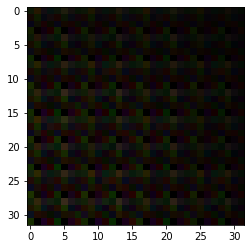

In [0]:
plt.imshow(np.clip(p_array[0], 0, 255).astype(int))

In [0]:
# Trains the generator on the loss: l * MSE - IQA
l = np.float32(0.01)
for i in range(80000):
  if i % 500 == 0:
    print("Iteration: " + str(i))
    predictions = generator(tf.convert_to_tensor(ref_images))
    scores_output = toy_model_trick2([tf.cast(predictions, tf.float32), tf.cast(tf.convert_to_tensor(ref_images), tf.float32)])
    print(l * tf.cast(generator_loss(ref_images, predictions), tf.float32) - tf.cast(tf.math.reduce_mean(scores_output), tf.float32))
    #print(generator_loss(predictions, ref_images))
  gen_train_step_full([toy_model_trick2], l)
  #gen_train_step_error()
  
predictions = generator(tf.convert_to_tensor(ref_images))

Iteration: 0


tf.Tensor(151.08519, shape=(), dtype=float32)
Iteration: 500
tf.Tensor(1.3749352, shape=(), dtype=float32)
Iteration: 1000
tf.Tensor(-1.8124094, shape=(), dtype=float32)
Iteration: 1500
tf.Tensor(-2.918745, shape=(), dtype=float32)
Iteration: 2000
tf.Tensor(-3.442461, shape=(), dtype=float32)
Iteration: 2500
tf.Tensor(-3.7775736, shape=(), dtype=float32)
Iteration: 3000
tf.Tensor(-4.0502696, shape=(), dtype=float32)
Iteration: 3500
tf.Tensor(-4.244502, shape=(), dtype=float32)
Iteration: 4000
tf.Tensor(-4.4192057, shape=(), dtype=float32)
Iteration: 4500
tf.Tensor(-4.578483, shape=(), dtype=float32)
Iteration: 5000
tf.Tensor(-4.715865, shape=(), dtype=float32)
Iteration: 5500
tf.Tensor(-4.8586936, shape=(), dtype=float32)
Iteration: 6000
tf.Tensor(-4.9536905, shape=(), dtype=float32)
Iteration: 6500
tf.Tensor(-5.0616264, shape=(), dtype=float32)
Iteration: 7000
tf.Tensor(-5.135659, shape=(), dtype=float32)
Iteration: 7500
tf.Tensor(-5.226712, shape=(), dtype=float32)
Ite

In [0]:
predictions = generator(tf.convert_to_tensor(ref_images, tf.float32))
#generator.save("/content/gdrive/My Drive/Colab Notebooks/generator.h5")
for i in range(25):
  plt.imsave("/content/gdrive/My Drive/Colab Notebooks/img" + str(i) + ".png", np.clip(np.array(predictions[i]), 0, 255).astype(np.uint8) / 255.0)

# Images

In [0]:
plt.imshow(np.clip(np.array(predictions[22]), 0, 255).astype(np.uint8))

NameError: ignored

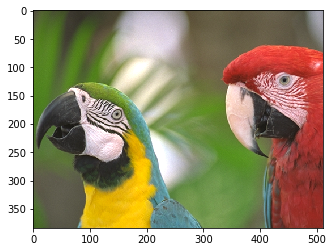

In [0]:
plt.imshow(np.array(ref_images[22]).astype(int))

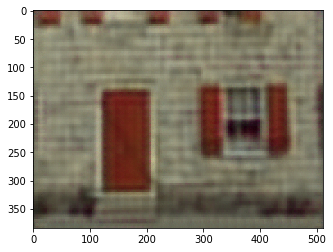

In [0]:
plt.imshow(np.array(predictions[0]).astype(int))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


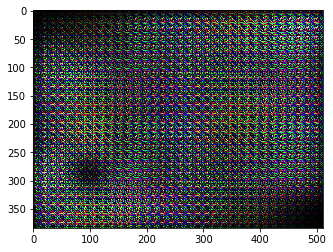

In [0]:
plt.imshow(np.array(predictions[24]).astype(int))

# Training metric with integrated fidelity measure

In [0]:
# Defines a DIQaM architecture with the patch-wise MSE between distorted and
# reference image added to the feature vectors of the patches

im_input_MSE = tf.keras.Input(shape=(192,32,32,3), batch_size=1)
ref_input_MSE = tf.keras.Input(shape=(192,32,32,3), batch_size=1)

m_conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), padding='same', activation='relu')
m_conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same', activation='relu')
m_conv3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same', activation='relu')
m_conv4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2), padding='same', activation='relu')
m_conv5 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=(2,2), padding='same', activation='relu')
def extractor_MSE(image):
  conv1 = (m_conv1(image))
  conv2 = (m_conv2(conv1))
  conv3 = (m_conv3(conv2))
  conv4 = (m_conv4(conv3))
  conv5 = (m_conv5(conv4))
  return tf.reshape(conv5, (192, 512))
  
def print_test(x):
  print(x)
  return extractor_MSE(x)

im_c_MSE = extractor_MSE(im_input_MSE[0])
ref_c_MSE = extractor_MSE(ref_input_MSE[0])
patch_mse = tf.keras.layers.Subtract()([im_input_MSE[0], ref_input_MSE[0]])
patch_mse2 = tf.keras.layers.Multiply()([patch_mse, patch_mse])
patch_mse = tf.keras.layers.Reshape((3,1))(tf.keras.layers.AveragePooling2D(pool_size=(32, 32))(patch_mse))
patch_mse = tf.keras.layers.Reshape((1,))(tf.keras.layers.AveragePooling1D(pool_size=3)(patch_mse))
patch_mse2 = tf.keras.layers.Reshape((3,1))(tf.keras.layers.AveragePooling2D(pool_size=(32, 32))(patch_mse2))
patch_mse2 = tf.keras.layers.Reshape((1,))(tf.keras.layers.AveragePooling1D(pool_size=3)(patch_mse2))
print(patch_mse2)

subbed_MSE = tf.keras.layers.Subtract()([im_c_MSE, ref_c_MSE])
subbed_MSE = tf.keras.layers.Concatenate()([subbed_MSE, patch_mse])
subbed_MSE = tf.keras.layers.Concatenate()([subbed_MSE, patch_mse2])
print(subbed_MSE)
dense1_MSE = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(subbed_MSE))
dense2_MSE = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(dense1_MSE))
dense3_MSE = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(dense2_MSE))
dense4_MSE = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(dense3_MSE))
out_MSE = tf.keras.layers.Dense(1)(dense4_MSE)
out_MSE = tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x, 0))(out_MSE)
#out_MSE = tf.keras.layers.Lambda(lambda x: tf.math.multiply(np.float32(9), tf.math.sigmoid(x)))(out_MSE)

toy_model_MSE = tf.keras.Model(inputs=[im_input_MSE, ref_input_MSE], outputs=out_MSE)
toy_model_MSE.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.MeanAbsoluteError())

Tensor("reshape_6/Identity:0", shape=(192, 1), dtype=float32)
Tensor("concatenate_1/Identity:0", shape=(192, 514), dtype=float32)


In [0]:
toy_model_MSE.fit_generator(adversarial.create_fr_image_batch(ref_images, np.array(range(25)), scores,
                                                image_names, True, decode=False, n_images=1, n_patches=192),
                   steps_per_epoch=500, epochs=750)

Epoch 1/750
500/500 [==============================] - 148s 296ms/step - loss: 872.1735
Epoch 2/750
500/500 [==============================] - 129s 259ms/step - loss: 265.1745
Epoch 3/750
500/500 [==============================] - 109s 217ms/step - loss: 125.3085
Epoch 4/750
500/500 [==============================] - 107s 213ms/step - loss: 75.8641
Epoch 5/750
500/500 [==============================] - 95s 189ms/step - loss: 100.1348
Epoch 6/750
500/500 [==============================] - 90s 179ms/step - loss: 43.9917
Epoch 7/750
500/500 [==============================] - 84s 168ms/step - loss: 34.3314
Epoch 8/750
500/500 [==============================] - 76s 152ms/step - loss: 17.8914
Epoch 9/750
500/500 [==============================] - 64s 128ms/step - loss: 15.4193
Epoch 10/750
500/500 [==============================] - 67s 133ms/step - loss: 16.6552
Epoch 11/750
500/500 [==============================] - 61s 122ms/step - loss: 15.4492
Epoch 12/750
500/500 [======================

In [0]:
toy_model_MSE.save("/content/gdrive/My Drive/Colab Notebooks/metric_MSE.h5")

In [0]:
toy_model_MSE = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/metric_MSE.h5")

In [0]:
# Train the generator with the patch-wise MSE WaDIQaM architecture
for i in range(1):
  if i % 500 == 0:
    print("Iteration: " + str(i))
    predictions = generator(tf.convert_to_tensor(ref_images))
    patches_gen = tf.image.extract_patches(predictions, [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
    patches_gen = tf.reshape(patches_gen, (25, 192, 32, 32, 3))
    patches_ref = tf.image.extract_patches(ref_images, [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
    patches_ref = tf.reshape(patches_ref, (25, 192, 32, 32, 3))
    scores_output = toy_model_MSE([tf.cast(patches_gen, tf.float32), tf.cast(patches_ref, tf.float32)])
    print(np.mean(scores_output))
  gen_train_step([toy_model_MSE], 1)
  #gen_train_step_error()
    
predictions = generator(tf.convert_to_tensor(ref_images))

Iteration: 0


ValueError: ignored

In [0]:
#predictions = generator(tf.convert_to_tensor(ref_images))
print(np.mean((np.array(predictions) - ref_images) ** 2))
print(np.mean(np.abs((np.array(predictions) - ref_images))))

197.7660710090167
8.542920298569538


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


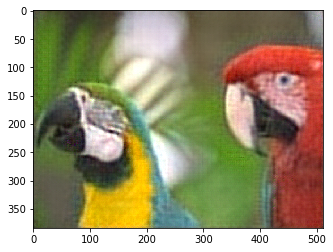

In [0]:
plt.imshow(np.array(predictions[22]).astype(int))

In [0]:
patches_gen = tf.image.extract_patches(np.array(predictions[0]).reshape((1,384,512,3)), [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
patches_gen = tf.reshape(patches_gen, (1, 192, 32, 32, 3))
patches_ref = tf.image.extract_patches(ref_images[0].reshape((1,384,512,3)), [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
patches_ref = tf.reshape(patches_ref, (1, 192, 32, 32, 3))
toy_model_MSE([tf.cast(patches_gen, tf.float32), tf.cast(patches_ref, tf.float32)])

<tf.Tensor: id=153781155, shape=(1,), dtype=float32, numpy=array([44.841843], dtype=float32)>

# Fidelity metric on full image

In [0]:
# Defines a DIQaM architecture with the MSE between the full reference and
# distorted images added at the end of the network through an additional regression

im_input_fullMSE = tf.keras.Input(shape=(384,512,3), batch_size=10)
ref_input_fullMSE = tf.keras.Input(shape=(384,512,3), batch_size=10)

m_conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), padding='same', activation='relu')
m_conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same', activation='relu')
m_conv3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same', activation='relu')
m_conv4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2), padding='same', activation='relu')
m_conv5 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=(2,2), padding='same', activation='relu')
def extractor_fullMSE(image):
  conv1 = (m_conv1(image))
  conv2 = (m_conv2(conv1))
  conv3 = (m_conv3(conv2))
  conv4 = (m_conv4(conv3))
  conv5 = (m_conv5(conv4))
  return tf.reshape(conv5, (-1, 192, 512))
  
def print_test(x):
  print(x)
  return extractor_fullMSE(x)

patches_gen = tf.image.extract_patches(im_input_fullMSE, [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
patches_gen = tf.reshape(patches_gen, (-1, 32, 32, 3))
patches_ref = tf.image.extract_patches(ref_input_fullMSE, [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
patches_ref = tf.reshape(patches_ref, (-1, 32, 32, 3))
im_c_fullMSE = extractor_fullMSE(patches_gen)
ref_c_fullMSE = extractor_fullMSE(patches_ref)
patch_fullMSE = tf.keras.layers.Subtract()([im_input_fullMSE, ref_input_fullMSE])
patch_fullMSE2 = tf.keras.layers.Multiply()([patch_fullMSE, patch_fullMSE])
patch_fullMSE = tf.keras.layers.Reshape((3,1))(tf.keras.layers.AveragePooling2D(pool_size=(384, 512))(patch_fullMSE))
patch_fullMSE = tf.keras.layers.Reshape((1,))(tf.keras.layers.AveragePooling1D(pool_size=3)(patch_fullMSE))
patch_fullMSE2 = tf.keras.layers.Reshape((3,1))(tf.keras.layers.AveragePooling2D(pool_size=(384, 512))(patch_fullMSE2))
patch_fullMSE2 = tf.keras.layers.Reshape((1,))(tf.keras.layers.AveragePooling1D(pool_size=3)(patch_fullMSE2))

subbed_fullMSE = tf.keras.layers.Subtract()([im_c_fullMSE, ref_c_fullMSE])
dense1_fullMSE = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(subbed_fullMSE))
dense2_fullMSE = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(dense1_fullMSE))
dense3_fullMSE = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(dense2_fullMSE))
out_fullMSE = tf.keras.layers.Dense(1)(dense3_fullMSE)
out_fullMSE = tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x, 1))(out_fullMSE)
out_fullMSE = tf.keras.layers.Reshape((1,))(out_fullMSE)
out_fullMSE = tf.keras.layers.Concatenate(axis=1)([out_fullMSE, tf.keras.layers.Reshape((1,))(patch_fullMSE)])
out_fullMSE = tf.keras.layers.Concatenate(axis=1)([out_fullMSE, tf.keras.layers.Reshape((1,))(patch_fullMSE2)])
out_fullMSE = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(8, activation='relu')(out_fullMSE))
out_fullMSE = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(8, activation='relu')(out_fullMSE))
out_fullMSE = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(1)(out_fullMSE))

toy_model_fullMSE = tf.keras.Model(inputs=[im_input_fullMSE, ref_input_fullMSE], outputs=out_fullMSE)
toy_model_fullMSE.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=tf.keras.losses.MeanSquaredError())

Tensor("input_4_1:0", shape=(10, 384, 512, 3), dtype=float32)
Tensor("Reshape_7:0", shape=(1920, 32, 32, 3), dtype=float32)
Tensor("Reshape_9:0", shape=(10, 192, 512), dtype=float32)
Tensor("dense_10_1/Identity:0", shape=(10, 192, 1), dtype=float32)
Tensor("lambda_1_2/Identity:0", shape=(10, 1), dtype=float32)
Tensor("reshape_11/Identity:0", shape=(10, 1), dtype=float32)
Tensor("concatenate_3/Identity:0", shape=(10, 3), dtype=float32)
Tensor("dropout_11/Identity:0", shape=(10, 1), dtype=float32)


In [0]:
toy_model_fullMSE.fit_generator(adversarial.create_fr_image_batch_full(ref_images, np.array(range(25)), scores,
                                                image_names, True, decode=False, n_images=5, n_patches=192),
                   steps_per_epoch=100, epochs=2)

In [0]:
images = np.reshape(np.array(ref_images[0]).astype(np.float32), (1, 384, 512, 3))
refs = np.reshape(np.array(ref_images[0]).astype(np.float32), (1, 384, 512, 3))
toy_model_fullMSE([images, refs])

<tf.Tensor: id=16867208, shape=(1, 1), dtype=float32, numpy=array([[3.8575208]], dtype=float32)>

In [0]:
# Train the generator using the full-image MSE WaDIQaM architecture
for i in range(30000):
  if i % 100 == 0:
    print("Iteration: " + str(i))
    predictions = generator(tf.convert_to_tensor(ref_images))
    scores_output = toy_model_fullMSE([tf.cast(predictions, tf.float32), tf.cast(ref_images, tf.float32)])
    print(np.mean(scores_output))
  gen_train_step_full([toy_model_fullMSE], 1)
  #gen_train_step_error()
    
predictions = generator(tf.convert_to_tensor(ref_images))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


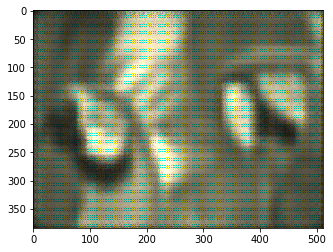

In [0]:
plt.imshow(np.array(predictions[22]).astype(int))

# Compute metrics for image folders

In [0]:
# Return the images of a given folder ordered by the given key function
def read_images(dir_name, key_fun=None):
    result = []
    image_names = sorted(os.listdir(dir_name), key=key_fun)
    for img_name in image_names:
        result.append(plt.imread(dir_name + "/" + img_name))
    return np.array(result)

# Computes objective scores for the images in the given folder and the given reference images
def compute_objective_scores_folder(folder_name, ref_images, key_fun=None, metrics=[], n_patches=0, im_dtype=tf.float32):
  images = tf.convert_to_tensor(read_images(folder_name, key_fun) * 255)[:,:,:,:3]
  ref_tensor = tf.convert_to_tensor(ref_images, tf.float32)
  psnrs = tf.image.psnr(images, ref_images.astype(np.float32), max_val=255.0)
  ssims = tf.image.ssim_multiscale(images, ref_images.astype(np.float32), max_val=255.0)
  if n_patches == 0:
    metric_results = [np.mean(m([tf.convert_to_tensor(images, dtype=im_dtype), tf.convert_to_tensor(ref_images, dtype=im_dtype)])) for m in metrics]
  else:
    metric_results = []
    for metric in metrics:
      in_list = []
      in_list_ref = []
      for j in range(n_patches):
        ul1 = np.random.randint(384-32)
        ul2 = np.random.randint(512-32)
        new_in = images[:, ul1:ul1+32, ul2:ul2+32, :]
        in_list.append(new_in)
        new_in_ref = ref_tensor[:, ul1:ul1+32, ul2:ul2+32, :]
        in_list_ref.append(new_in_ref)
      input_tensor = tf.stack(in_list, 1)
      input_tensor_ref = tf.stack(in_list_ref, 1)
      metric_results.append(np.mean(metric([input_tensor, input_tensor_ref])))

  res = [np.mean(ssims), np.mean(psnrs)]
  res.append(generator_loss(images, ref_images).numpy())
  res.extend(metric_results)

  return res

In [0]:
# Computes objective scores for the images obtained by applying the given generator
# to the given reference images
def compute_objective_scores(generator_name, ref_images, metrics=[], n_patches=0, im_dtype=tf.float32):
  gen = tf.keras.models.load_model(generator_name)
  ref_tensor = tf.convert_to_tensor(ref_images, tf.float32)
  images = tf.cast(gen(tf.convert_to_tensor(ref_images, im_dtype)), tf.float32)
  psnrs = tf.image.psnr(images, ref_images.astype(np.float32), max_val=255.0)
  ssims = tf.image.ssim_multiscale(images, ref_images.astype(np.float32), max_val=255.0)
  if n_patches == 0:
    metric_results = [np.mean(m([tf.convert_to_tensor(images, dtype=im_dtype), tf.convert_to_tensor(ref_images, dtype=im_dtype)])) for m in metrics]
  else:
    metric_results = []
    for metric in metrics:
      in_list = []
      in_list_ref = []
      for j in range(n_patches):
        ul1 = np.random.randint(384-32)
        ul2 = np.random.randint(512-32)
        new_in = images[:, ul1:ul1+32, ul2:ul2+32, :]
        in_list.append(new_in)
        new_in_ref = ref_tensor[:, ul1:ul1+32, ul2:ul2+32, :]
        in_list_ref.append(new_in_ref)
      input_tensor = tf.stack(in_list, 1)
      input_tensor_ref = tf.stack(in_list_ref, 1)
      metric_results.append(np.mean(metric([input_tensor, input_tensor_ref])))

  res = [np.mean(ssims), np.mean(psnrs)]
  res.append(generator_loss(images, ref_images).numpy())
  res.extend(metric_results)

  return res

In [0]:
folders_0 = [
           "/content/gdrive/My Drive/Colab Notebooks/generator_mse.h5",
           "/content/gdrive/My Drive/Colab Notebooks/generator_wadiqam_r_l=5.h5",
           "/content/gdrive/My Drive/Colab Notebooks/generator_wadiqam_r_l=1.h5",
           "/content/gdrive/My Drive/Colab Notebooks/generator_wadiqam_r_l=0.1.h5",
           "/content/gdrive/My Drive/Colab Notebooks/generator_wadiqam_r_l=0.01.h5"
]

res_0 = []
for folder in folders_0:
  res_0.extend(compute_objective_scores(folder, ref_images, [wadiqam_r, wadiqam_r_1, wadiqam_r_0], 64))

In [0]:
folders_1 = [
           "/content/gdrive/My Drive/Colab Notebooks/generator_mse.h5",
           "/content/gdrive/My Drive/Colab Notebooks/generator_wadiqam_r_1adv_l=5.h5",
           "/content/gdrive/My Drive/Colab Notebooks/generator_wadiqam_r_1adv_l=1.h5",
           "/content/gdrive/My Drive/Colab Notebooks/generator_wadiqam_r_1adv_l=0.1.h5",
           "/content/gdrive/My Drive/Colab Notebooks/generator_wadiqam_r_1adv_l=0.01.h5"
]

res_1 = []
for folder in folders_1:
  res_1.extend(compute_objective_scores(folder, ref_images, [wadiqam_r, wadiqam_r_1, wadiqam_r_0], 64))

In [0]:
folders_2 = [
           "/content/gdrive/My Drive/Colab Notebooks/generator_mse.h5",
           "/content/gdrive/My Drive/Colab Notebooks/generator_wadiqam_r_2adv_l=5.h5",
           "/content/gdrive/My Drive/Colab Notebooks/generator_wadiqam_r_2adv_l=1.h5",
           "/content/gdrive/My Drive/Colab Notebooks/generator_wadiqam_r_2adv_l=0.1.h5",
           "/content/gdrive/My Drive/Colab Notebooks/generator_wadiqam_r_2adv_l=0.01.h5"
]

res_2 = []
for folder in folders_2:
  res_2.extend(compute_objective_scores(folder, ref_images, [wadiqam_r, wadiqam_r_1, wadiqam_r_0], 64))

Text(0.5, 0, 'Lambda')

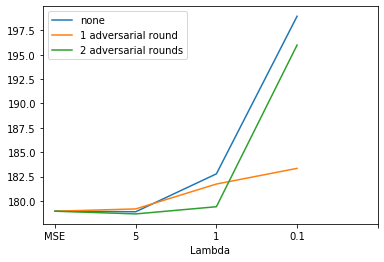

In [0]:
asd = 2
plt.plot(res_0[asd:-6:6])
plt.plot(res_1[asd:-6:6])
plt.plot(res_2[asd:-6:6])
plt.legend(["none", "1 adversarial round", "2 adversarial rounds"])
plt.xticks(np.arange(5), ["MSE", "5", "1", "0.1"])
plt.xlabel("Lambda")

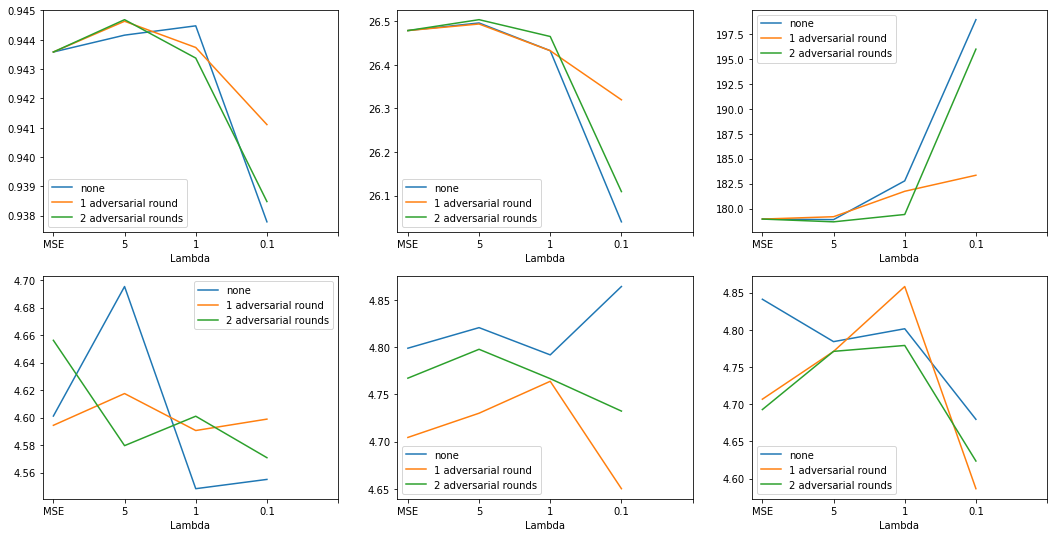

In [0]:
fig = plt.figure(figsize=(18,9))
for asd in range(6):
  plt.subplot(2,3,asd+1)
  plt.plot(res_0[asd:-6:6])
  plt.plot(res_1[asd:-6:6])
  plt.plot(res_2[asd:-6:6])
  plt.legend(["none", "1 adversarial round", "2 adversarial rounds"])
  plt.xticks(np.arange(5), ["MSE", "5", "1", "0.1"])
  plt.xlabel("Lambda")
plt.show()
plt.close(fig)

In [0]:
def key_fun(x):
  return int(x[3:-4])

folders_0 = [
           "/content/gdrive/My Drive/Colab Notebooks/Images_mse",
           "/content/gdrive/My Drive/Colab Notebooks/Images_wadiqam_l=5",
           "/content/gdrive/My Drive/Colab Notebooks/Images_wadiqam_l=1",
           "/content/gdrive/My Drive/Colab Notebooks/Images_wadiqam_l=0.1"
]
folders_1 = [
           "/content/gdrive/My Drive/Colab Notebooks/Images_mse",
           "/content/gdrive/My Drive/Colab Notebooks/Images_wadiqam_1adv_l=5",
           "/content/gdrive/My Drive/Colab Notebooks/Images_wadiqam_1adv_l=1",
           "/content/gdrive/My Drive/Colab Notebooks/Images_wadiqam_1adv_l=0.1"
]
folders_2 = [
           "/content/gdrive/My Drive/Colab Notebooks/Images_mse",
           "/content/gdrive/My Drive/Colab Notebooks/Images_wadiqam_2adv_l=5",
           "/content/gdrive/My Drive/Colab Notebooks/Images_wadiqam_2adv_l=1",
           "/content/gdrive/My Drive/Colab Notebooks/Images_wadiqam_2adv_l=0.1"
]

g_res_0 = []
g_res_0_csiq = []
for folder in folders_0:
  g_res_0.extend(compute_objective_scores_folder(folder, ref_images, key_fun, [], 0))

g_res_1 = []
g_res_1_csiq = []
for folder in folders_1:
  g_res_1.extend(compute_objective_scores_folder(folder, ref_images, key_fun, [], 0))

g_res_2 = []
g_res_2_csiq = []
for folder in folders_2:
  g_res_2.extend(compute_objective_scores_folder(folder, ref_images, key_fun, [], 64))

['img0.png', 'img1.png', 'img2.png', 'img3.png', 'img4.png', 'img5.png', 'img6.png', 'img7.png', 'img8.png', 'img9.png', 'img10.png', 'img11.png', 'img12.png', 'img13.png', 'img14.png', 'img15.png', 'img16.png', 'img17.png', 'img18.png', 'img19.png', 'img20.png', 'img21.png', 'img22.png', 'img23.png', 'img24.png']
['img0.png', 'img1.png', 'img2.png', 'img3.png', 'img4.png', 'img5.png', 'img6.png', 'img7.png', 'img8.png', 'img9.png', 'img10.png', 'img11.png', 'img12.png', 'img13.png', 'img14.png', 'img15.png', 'img16.png', 'img17.png', 'img18.png', 'img19.png', 'img20.png', 'img21.png', 'img22.png', 'img23.png', 'img24.png']
['img0.png', 'img1.png', 'img2.png', 'img3.png', 'img4.png', 'img5.png', 'img6.png', 'img7.png', 'img8.png', 'img9.png', 'img10.png', 'img11.png', 'img12.png', 'img13.png', 'img14.png', 'img15.png', 'img16.png', 'img17.png', 'img18.png', 'img19.png', 'img20.png', 'img21.png', 'img22.png', 'img23.png', 'img24.png']
['img0.png', 'img1.png', 'img2.png', 'img3.png', 'im

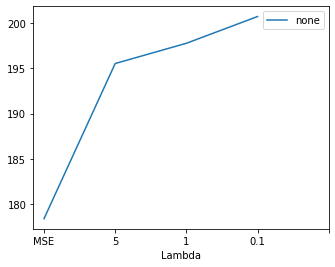

In [0]:
fig = plt.figure(figsize=(18,9))
asd=2
plt.subplot(2,3,asd+1)
plt.plot(g_res_0[asd::3])
#plt.plot(g_res_1[asd::3])
#plt.plot(g_res_2[asd::3])
plt.legend(["none", "1 adversarial round", "2 adversarial rounds"])
plt.xticks(np.arange(5), ["MSE", "5", "1", "0.1"])#, "0.01"])
plt.xlabel("Lambda")
plt.show()
plt.close(fig)

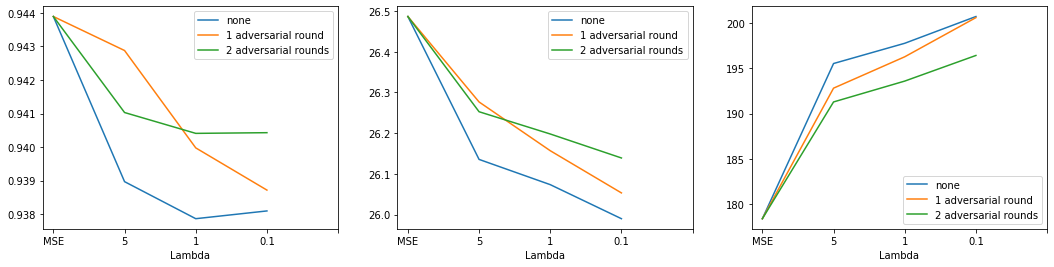

In [0]:
fig = plt.figure(figsize=(18,9))
for asd in range(3):
  plt.subplot(2,3,asd+1)
  plt.plot(g_res_0[asd::3])
  plt.plot(g_res_1[asd::3])
  plt.plot(g_res_2[asd::3])
  plt.legend(["none", "1 adversarial round", "2 adversarial rounds"])
  plt.xticks(np.arange(5), ["MSE", "5", "1", "0.1"])#, "0.01"])
  plt.xlabel("Lambda")
plt.show()
plt.close(fig)

# Saving auto-encoder progress

In this section I saved the images produced by an autoencoder throughout the training process to get a better idea of what happened during training.

In [0]:
l = np.float32(0.0000000001)
dirname = "/content/gdrive/My Drive/Colab Notebooks/progress_early"
for i in range(2000):
  if i % 500 == 0:
    print("Iteration: " + str(i))
    predictions = generator(tf.convert_to_tensor(ref_images))
    patches_gen = tf.image.extract_patches(predictions, [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
    patches_gen = tf.reshape(patches_gen, (25, 192, 32, 32, 3))
    patches_ref = tf.image.extract_patches(ref_images, [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
    patches_ref = tf.reshape(patches_ref, (25, 192, 32, 32, 3))
    scores_output = toy_model([tf.cast(patches_gen, tf.float32), tf.cast(patches_ref, tf.float32)])
    print(l * generator_loss(ref_images, predictions) - np.mean(scores_output))
    """
    try:
      os.mkdir(dirname)
      print("Dir created")
    except FileExistsError:
      print("Dir exists")
    for j in range(25):
      plt.imsave((dirname + "/img{0:04d}{1:02d}.png").format(i//100, j), np.clip(np.array(predictions[j]), 0, 255).astype(np.uint8) / 255.0)
    """
  gen_train_step([toy_model_trick1], l)
  #gen_train_step_error()
    
predictions = generator(tf.convert_to_tensor(ref_images))

Iteration: 0
tf.Tensor(-8.883780235961117, shape=(), dtype=float64)
Iteration: 500
tf.Tensor(-8.894393678269614, shape=(), dtype=float64)
Iteration: 1000
tf.Tensor(-8.905653711968636, shape=(), dtype=float64)
Iteration: 1500
tf.Tensor(-8.914953945202132, shape=(), dtype=float64)


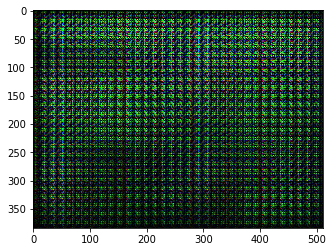

In [0]:
plt.imshow(np.clip(np.array(predictions[5]), 0, 255).astype(np.uint8))

In [0]:
os.mkdir("/content/gdrive/My Drive/Colab Notebooks/progress")
for i in range(25):
  plt.imsave("/content/gdrive/My Drive/Colab Notebooks/progress/img" + str(i) + ".png", np.clip(np.array(predictions[i]), 0, 255).astype(np.uint8) / 255.0)

In [0]:
test = ["{0:04d}{1:02d}".format(i, j) for i in range(5) for j in range(25)]

In [0]:
patches_gen = tf.image.extract_patches(np.array(predictions[5]).reshape((1,384,512,3)), [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
patches_gen = tf.reshape(patches_gen, (1, 192, 32, 32, 3))
patches_ref = tf.image.extract_patches(np.array(ref_images[5]).reshape((1,384,512,3)), [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
patches_ref = tf.reshape(patches_ref, (1, 192, 32, 32, 3))
#patches_gen, patches_ref = extract_random_patches(predictions[0:1], ref_images[0:1], 192, 32)
print(toy_model([tf.cast(patches_gen, tf.float32), tf.cast(patches_ref, tf.float32)]))

tf.Tensor([10.582142], shape=(1,), dtype=float32)


In [0]:
x = tf.ones((2, 2))

with tf.GradientTape() as t:
  t.watch(x)
  y = tf.reduce_sum(x)
  z = -tf.multiply(y, y)

# Use the tape to compute the derivative of z with respect to the
# intermediate value y.
dz_dy = t.gradient(z, y)
print(dz_dy.numpy())

-8.0


# Wadiqam

In [0]:
# Defines a WaDIQaM architecture using a sigmoid at the output

im_input_wadiqam = tf.keras.Input(shape=(384, 512 ,3), batch_size=10)
ref_input_wadiqam = tf.keras.Input(shape=(384, 512 ,3), batch_size=10)

i_conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), padding='same', activation='relu')
i_conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same', activation='relu')
i_conv3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same', activation='relu')
i_conv4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2), padding='same', activation='relu')
i_conv5 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=(2,2), padding='same', activation='relu')
def extractor_wadiqam(image):
  conv1 = (i_conv1(image))
  conv2 = (i_conv2(conv1))
  conv3 = (i_conv3(conv2))
  conv4 = (i_conv4(conv3))
  conv5 = (i_conv5(conv4))
  return tf.reshape(conv5, (-1, 192, 512))
  
def print_test(x):
  print(x)
  return extractor_wadiqam(x)

patches_gen_wadiqam = tf.image.extract_patches(im_input_wadiqam, [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
patches_gen_wadiqam = tf.reshape(patches_gen_wadiqam, (-1, 32, 32, 3))
patches_ref_wadiqam = tf.image.extract_patches(ref_input_wadiqam, [1,32,32,1], [1,32,32,1], [1,1,1,1], 'SAME')
patches_ref_wadiqam = tf.reshape(patches_ref_wadiqam, (-1, 32, 32, 3))
im_c_wadiqam = extractor_wadiqam(patches_gen_wadiqam)
ref_c_wadiqam = extractor_wadiqam(patches_ref_wadiqam)

subbed_wadiqam = tf.keras.layers.Subtract()([im_c_wadiqam, ref_c_wadiqam])
dense1_wadiqam = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(subbed_wadiqam))
dense2_wadiqam = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(dense1_wadiqam))
out_wadiqam = tf.keras.layers.Dense(1)(dense2_wadiqam)

dense1_wadiqam_weights = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(subbed_wadiqam))
dense2_wadiqam_weights = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(dense1_wadiqam_weights))
out_wadiqam_weights = tf.keras.layers.Dense(1)(dense2_wadiqam_weights)
out_wadiqam_weights = tf.keras.layers.Lambda(lambda x: tf.math.exp(x))(out_wadiqam_weights)
weight_sum = tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x, 1))(out_wadiqam_weights)
weight_sum = tf.keras.layers.Lambda(lambda x: tf.math.reciprocal(x))(weight_sum)

out_wadiqam = tf.keras.layers.Multiply()([out_wadiqam, out_wadiqam_weights])
out_wadiqam = tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x, 1))(out_wadiqam)
out_wadiqam = tf.keras.layers.Multiply()([out_wadiqam, weight_sum])
out_wadiqam = tf.keras.layers.Lambda(lambda x: tf.math.multiply(np.float32(9), tf.math.sigmoid(x)))(out_wadiqam)

toy_model_wadiqam = tf.keras.Model(inputs=[im_input_wadiqam, ref_input_wadiqam], outputs=out_wadiqam)
toy_model_wadiqam.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss=tf.keras.losses.MeanAbsoluteError())

In [0]:
toy_model_wadiqam.fit_generator(adversarial.create_fr_image_batch_full(ref_images, np.array(range(25)), scores,
                                                image_names, True, decode=False, n_images=1, n_patches=192),
                   steps_per_epoch=500, epochs=50)

Epoch 1/50
500/500 [==============================] - 222s 443ms/step - loss: 1.0634
Epoch 2/50
500/500 [==============================] - 214s 428ms/step - loss: 0.4307
Epoch 3/50
500/500 [==============================] - 194s 389ms/step - loss: 0.4091
Epoch 4/50
500/500 [==============================] - 186s 373ms/step - loss: 0.3381
Epoch 5/50
500/500 [==============================] - 167s 333ms/step - loss: 0.3312
Epoch 6/50
500/500 [==============================] - 176s 352ms/step - loss: 0.3336
Epoch 7/50
500/500 [==============================] - 159s 319ms/step - loss: 0.3204
Epoch 8/50
500/500 [==============================] - 147s 293ms/step - loss: 0.3117
Epoch 9/50
500/500 [==============================] - 151s 303ms/step - loss: 0.3105
Epoch 10/50
500/500 [==============================] - 142s 285ms/step - loss: 0.3097
Epoch 11/50
500/500 [==============================] - 142s 285ms/step - loss: 0.2778
Epoch 12/50
500/500 [==============================] - 116s 232

In [0]:
toy_model_wadiqam.save("/content/gdrive/My Drive/Colab Notebooks/metric_wadiqam.h5")

NameError: ignored

In [0]:
for i in range(10):
  toy_model_wadiqam.fit_generator(adversarial.create_fr_image_batch_full(ref_images, np.array(range(25)), scores,
                    image_names, True, decode=False, n_images=1, n_patches=192),
                   steps_per_epoch=500, epochs=50)
  toy_model_wadiqam.save("/content/gdrive/My Drive/Colab Notebooks/metric_wadiqam.h5")

Epoch 1/50
500/500 [==============================] - 29s 58ms/step - loss: 0.2283
Epoch 2/50
500/500 [==============================] - 29s 57ms/step - loss: 0.2217
Epoch 3/50
500/500 [==============================] - 29s 57ms/step - loss: 0.2040
Epoch 4/50
500/500 [==============================] - 29s 58ms/step - loss: 0.2294
Epoch 5/50
500/500 [==============================] - 29s 57ms/step - loss: 0.2080
Epoch 6/50
500/500 [==============================] - 29s 57ms/step - loss: 0.2279
Epoch 7/50
500/500 [==============================] - 29s 57ms/step - loss: 0.2215
Epoch 8/50
500/500 [==============================] - 29s 57ms/step - loss: 0.1826
Epoch 9/50
500/500 [==============================] - 29s 58ms/step - loss: 0.2489
Epoch 10/50
500/500 [==============================] - 28s 57ms/step - loss: 0.2149
Epoch 11/50
500/500 [==============================] - 29s 57ms/step - loss: 0.2162
Epoch 12/50
500/500 [==============================] - 28s 56ms/step - loss: 0.2249
E

In [0]:
toy_model_wadiqam = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/metric_wadiqam_adv2.h5")

In [0]:
# Train the generator using loss: l * MSE - IQA
l = np.float32(0.01)
for i in range(60000):
  if i % 500 == 0:
    print("Iteration: " + str(i))
    predictions = generator(tf.convert_to_tensor(ref_images, tf.float32))
    scores_output = toy_model_wadiqam_5([tf.cast(predictions, tf.float32), tf.cast(tf.convert_to_tensor(ref_images), tf.float32)])
    print(l * tf.cast(generator_loss(ref_images, predictions), tf.float32) - tf.cast(tf.math.reduce_mean(scores_output), tf.float32))
    #print(generator_loss(predictions, ref_images))
  gen_train_step_full([toy_model_wadiqam_5], l)
  #gen_train_step_error()
  
predictions = generator(tf.convert_to_tensor(ref_images, tf.float32))

In [0]:
# Continue training and save the generator
for j in range(3):
  for i in range(20000):
    if i % 500 == 0:
      print("Iteration: " + str(i))
      predictions = generator(tf.convert_to_tensor(ref_images, tf.float32))
      scores_output = toy_model_wadiqam_5([tf.cast(predictions, tf.float32), tf.cast(tf.convert_to_tensor(ref_images), tf.float32)])
      print(l * tf.cast(generator_loss(ref_images, predictions), tf.float32) - tf.cast(tf.math.reduce_mean(scores_output), tf.float32))
      #print(generator_loss(predictions, ref_images))
    gen_train_step_full([toy_model_wadiqam_5], l)
    #gen_train_step_error()
  generator.save("/content/gdrive/My Drive/Colab Notebooks/generator_bis.h5")

predictions = generator(tf.convert_to_tensor(ref_images, tf.float32))

# Adversarial training

In [0]:
toy_model_wadiqam = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/metric_wadiqam.h5")
toy_model_wadiqam_1 = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/metric_wadiqam_adv.h5")
toy_model_wadiqam_2 = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/metric_wadiqam_adv2.h5")

In [0]:
toy_model_wadiqam_4 = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/metric_wadiqam_adv4.h5")
toy_model_wadiqam_5 = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/metric_wadiqam_adv5.h5")

In [0]:
# Create a generator for all the distorted images of TID2013
gen = adversarial.create_fr_image_batch_full(ref_images, np.array(range(25)), scores,
                                                image_names, False, decode=False, n_images=25, n_patches=192)

In [0]:
# Iterate through all the images and compute adversarial perturbations through
# gradient ascent
counter = 0
i = 0
while i < 3000 // 25:
  im, score = next(gen)
  dist_tensor = tf.convert_to_tensor(im[0])
  ref_tensor = tf.convert_to_tensor(im[1])
  cont = True
  while cont:
    clear_output(wait=True)
    with tf.GradientTape() as gen_tape:
      gen_tape.watch(dist_tensor)
      scores_output = toy_model_wadiqam_2([tf.cast(dist_tensor, tf.float32), tf.cast(ref_tensor, tf.float32)])
      print("{0}: {1}".format(i, np.mean(scores_output)))
      if np.mean(scores_output) > np.mean(score) + 1:
        cont = False
    dist_tensor += 35*gen_tape.gradient(scores_output, dist_tensor)

  mae = 0
  for j in range(25):
    diff_im = dist_tensor.numpy()[j] - im[0][j]
    mae += np.mean(np.abs(diff_im))
    res = np.clip((im[0][j] + (10 * diff_im)) / 255.0, 0, 1)
    plt.imsave("/content/gdrive/My Drive/Colab Notebooks/adversarial_ims2/test{0}.png".format(counter), res)
    counter += 1
  print(mae / 25.0)
  i += 1

100: 5.348143100738525


In [0]:
# Computes adversarial noise for a single batch of images, used for testing purposes
im, score = next(gen)
dist_tensor = tf.convert_to_tensor(im[0])
ref_tensor = tf.convert_to_tensor(im[1])
for i in range(2000):
  clear_output(wait=True)
  with tf.GradientTape() as gen_tape:
    gen_tape.watch(dist_tensor)
    scores_output = toy_model_wadiqam_4([tf.cast(dist_tensor, tf.float32), tf.cast(ref_tensor, tf.float32)])
    print(np.mean(scores_output))
  dist_tensor += 100*gen_tape.gradient(scores_output, dist_tensor)

8.669683


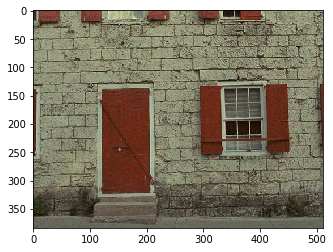

In [0]:
plt.imshow(im[0][0].astype(int))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


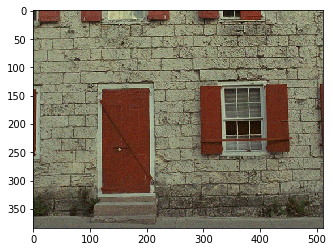

In [0]:
plt.imshow(dist_tensor.numpy()[0].astype(int))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.469371835549181


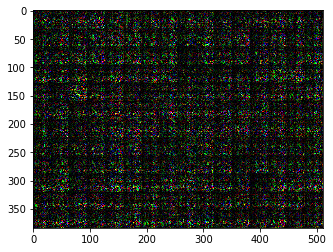

In [0]:
# Visualize the adversarial perturbation
diff_im = dist_tensor.numpy()[0] - im[0][0]
print(np.mean(np.abs(diff_im)))
plt.imshow(100 * diff_im / 255.0)

In [0]:
# Continue training a metric using the adversarial images and the original database
toy_model_wadiqam_4.fit_generator(adversarial.create_fr_image_batch_full(ref_images, np.array(range(25)), scores,
                    image_names, True, "adversarial_ims2", decode=False, n_images=1, n_patches=192),
                   steps_per_epoch=3000, epochs=5)

Epoch 1/5
3000/3000 [==============================] - 663s 221ms/step - loss: 0.7201
Epoch 2/5
3000/3000 [==============================] - 486s 162ms/step - loss: 0.5875
Epoch 3/5
3000/3000 [==============================] - 397s 132ms/step - loss: 0.5317
Epoch 4/5
3000/3000 [==============================] - 325s 108ms/step - loss: 0.5144
Epoch 5/5
3000/3000 [==============================] - 292s 97ms/step - loss: 0.5212


In [0]:
toy_model_wadiqam_4.save("/content/gdrive/My Drive/Colab Notebooks/metric_wadiqam_adv5.h5")

In [0]:
wdq_s = toy_model_wadiqam([tf.convert_to_tensor(predictions, tf.float32), tf.convert_to_tensor(ref_images, tf.float32)])
print(np.mean(wdq_s))
print(wdq_s)

5.018451
tf.Tensor(
[[3.7663238]
 [5.1000824]
 [5.4048853]
 [6.0335608]
 [3.1205661]
 [4.593094 ]
 [5.2237835]
 [3.6319883]
 [5.717713 ]
 [5.982174 ]
 [4.093671 ]
 [6.111473 ]
 [2.9258845]
 [3.5881653]
 [5.453559 ]
 [6.0433803]
 [5.294285 ]
 [3.7372363]
 [5.0610046]
 [6.456119 ]
 [5.2554097]
 [4.722305 ]
 [5.6573668]
 [4.009592 ]
 [8.477664 ]], shape=(25, 1), dtype=float32)


# Random patches metrics

In [0]:
# Defines a WaDIQaM metric designed to take random patches as input

def make_wadiqam_model_r():
  im_input_wadiqam = tf.keras.Input(shape=(64, 32, 32 ,3), batch_size=10)
  ref_input_wadiqam = tf.keras.Input(shape=(64, 32, 32 ,3), batch_size=10)

  i_conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), padding='same', activation='relu')
  i_conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same', activation='relu')
  i_conv3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same', activation='relu')
  i_conv4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2), padding='same', activation='relu')
  i_conv5 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=(2,2), padding='same', activation='relu')
  def extractor_wadiqam(image):
    conv1 = (i_conv1(image))
    conv2 = (i_conv2(conv1))
    conv3 = (i_conv3(conv2))
    conv4 = (i_conv4(conv3))
    conv5 = (i_conv5(conv4))
    return tf.reshape(conv5, (-1, 64, 512))
    
  def print_test(x):
    print(x)
    return extractor_wadiqam(x)

  patches_gen_wadiqam = tf.reshape(im_input_wadiqam, (-1, 32, 32, 3))
  patches_ref_wadiqam = tf.reshape(ref_input_wadiqam, (-1, 32, 32, 3))
  im_c_wadiqam = extractor_wadiqam(patches_gen_wadiqam)
  ref_c_wadiqam = extractor_wadiqam(patches_ref_wadiqam)

  subbed_wadiqam = tf.keras.layers.Subtract()([im_c_wadiqam, ref_c_wadiqam])
  dense1_wadiqam = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(subbed_wadiqam))
  dense2_wadiqam = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(dense1_wadiqam))
  out_wadiqam = tf.keras.layers.Dense(1)(dense2_wadiqam)

  dense1_wadiqam_weights = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(subbed_wadiqam))
  dense2_wadiqam_weights = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(dense1_wadiqam_weights))
  out_wadiqam_weights = tf.keras.layers.Dense(1)(dense2_wadiqam_weights)
  out_wadiqam_weights = tf.keras.layers.Lambda(lambda x: tf.math.exp(x))(out_wadiqam_weights)
  weight_sum = tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x, 1))(out_wadiqam_weights)
  weight_sum = tf.keras.layers.Lambda(lambda x: tf.math.reciprocal(x))(weight_sum)

  out_wadiqam = tf.keras.layers.Multiply()([out_wadiqam, out_wadiqam_weights])
  out_wadiqam = tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x, 1))(out_wadiqam)
  out_wadiqam = tf.keras.layers.Multiply()([out_wadiqam, weight_sum])
  out_wadiqam = tf.keras.layers.Lambda(lambda x: tf.math.multiply(np.float32(9), tf.math.sigmoid(x)))(out_wadiqam)

  toy_model_wadiqam = tf.keras.Model(inputs=[im_input_wadiqam, ref_input_wadiqam], outputs=out_wadiqam)
  toy_model_wadiqam.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss=tf.keras.losses.MeanAbsoluteError())
  return toy_model_wadiqam

In [0]:
wadiqam_r = make_wadiqam_model_r()

In [0]:
wadiqam_r = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/metric_wadiqam_r_2adv.h5")
wadiqam_r_1 = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/metric_wadiqam_r_1adv.h5")
wadiqam_r_0 = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/metric_wadiqam_r.h5")

In [0]:
# Train the metric
for i in range(10):
  wadiqam_r.fit_generator(adversarial.create_fr_image_batch(ref_images, np.array(range(25)), scores,
                    image_names, True, decode=False, n_images=10, n_patches=64),
                   steps_per_epoch=300, epochs=10)
  wadiqam_r.save("/content/gdrive/My Drive/Colab Notebooks/metric_wadiqam_r.h5")

Epoch 1/10
300/300 [==============================] - 598s 2s/step - loss: 0.6835
Epoch 2/10
300/300 [==============================] - 353s 1s/step - loss: 0.6675
Epoch 3/10
300/300 [==============================] - 234s 781ms/step - loss: 0.6668
Epoch 4/10
300/300 [==============================] - 183s 610ms/step - loss: 0.6503
Epoch 5/10
300/300 [==============================] - 177s 590ms/step - loss: 0.6472
Epoch 6/10
300/300 [==============================] - 146s 487ms/step - loss: 0.6506
Epoch 7/10
300/300 [==============================] - 142s 472ms/step - loss: 0.6363
Epoch 8/10
300/300 [==============================] - 136s 453ms/step - loss: 0.6375
Epoch 9/10
300/300 [==============================] - 137s 456ms/step - loss: 0.6245
Epoch 10/10
300/300 [==============================] - 135s 451ms/step - loss: 0.6155
Epoch 1/10
300/300 [==============================] - 135s 450ms/step - loss: 0.6292
Epoch 2/10
300/300 [==============================] - 134s 446ms/step 

In [0]:
# Create a generator for the ditorted images of TID2013
n_im = 25
gen = adversarial.create_fr_image_batch_full(ref_images, np.array(range(25)), scores,
                                                image_names, False, decode=False, n_images=n_im, n_patches=192, start_idx=0*25)

In [0]:
# Perform adversarial training
i=0
counter = i * 25
while i < 120:
  im, score = next(gen)
  dist_tensor = tf.convert_to_tensor(im[0])
  ref_tensor = tf.convert_to_tensor(im[1])
  cont = True
  while cont:
    clear_output(wait=True)
    with tf.GradientTape() as gen_tape:
      gen_tape.watch(dist_tensor)
      in_list = []
      in_list_ref = []
      
      for j in range(128):
        ul1 = np.random.randint(384-32)
        ul2 = np.random.randint(512-32)
        new_in = dist_tensor[:, ul1:ul1+32, ul2:ul2+32, :]
        in_list.append(new_in)

        new_in_ref = ref_tensor[:, ul1:ul1+32, ul2:ul2+32, :]
        in_list_ref.append(new_in_ref)

      input_tensor = tf.stack(in_list, 1)
      input_tensor_ref = tf.stack(in_list_ref, 1)
      scores_output = wadiqam_r([tf.cast(input_tensor, tf.float32), tf.cast(input_tensor_ref, tf.float32)])
      print("{0}: {1}".format(i, np.mean(scores_output)))
      if np.mean(scores_output) > np.mean(score) + 0.5:
        cont = False
    dist_tensor += 2000*gen_tape.gradient(scores_output, dist_tensor)

  mae = 0
  for j in range(25):
    diff_im = dist_tensor.numpy()[j] - im[0][j]
    mae += np.mean(np.abs(diff_im))
    res = np.clip((im[0][j] + (3 * diff_im)) / 255.0, 0, 1)
    plt.imsave("/content/gdrive/My Drive/Colab Notebooks/adversarial_ims2/test{0}.png".format(counter), res)
    counter += 1
  print(mae / 25.0)

  i += 1

89: 6.558795928955078
0.02727630209419378


In [0]:
# Compute adversarial noise for a single batch, for testing
im, score = next(gen)
dist_tensor = tf.convert_to_tensor(im[0])
ref_tensor = tf.convert_to_tensor(im[1])
score = 0;
while score < 7.75:
  clear_output(wait=True)
  with tf.GradientTape() as gen_tape:
    gen_tape.watch(dist_tensor)
    in_list = []
    in_list_ref = []
    
    for j in range(64):
      ul1 = np.random.randint(384-32)
      ul2 = np.random.randint(512-32)
      new_in = dist_tensor[:, ul1:ul1+32, ul2:ul2+32, :]
      in_list.append(new_in)

      new_in_ref = ref_tensor[:, ul1:ul1+32, ul2:ul2+32, :]
      in_list_ref.append(new_in_ref)

    input_tensor = tf.stack(in_list, 1)
    input_tensor_ref = tf.stack(in_list_ref, 1)
    scores_output = wadiqam_r([tf.cast(input_tensor, tf.float32), tf.cast(input_tensor_ref, tf.float32)])
    score = np.mean(scores_output)
    print(score)
  dist_tensor += 1000*gen_tape.gradient(scores_output, dist_tensor)

7.82037


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


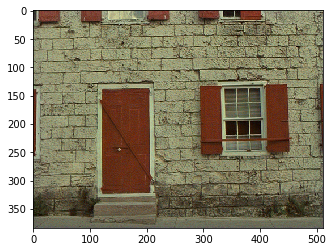

In [0]:
plt.imshow(dist_tensor.numpy()[0].astype(int))

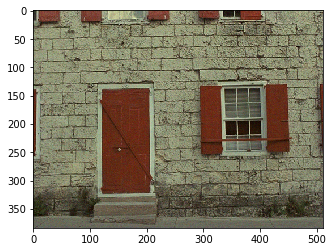

In [0]:
test_im = (255 * plt.imread("/content/gdrive/My Drive/Colab Notebooks/adversarial_ims2/test0.png")[:,:,:3]).astype(int)
plt.imshow(test_im[:,:,:3])

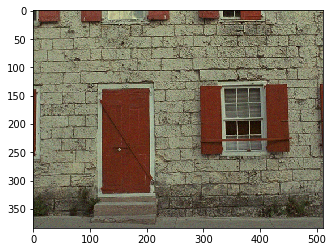

In [0]:
plt.imshow(im[0][0].astype(int))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6.074656197912348


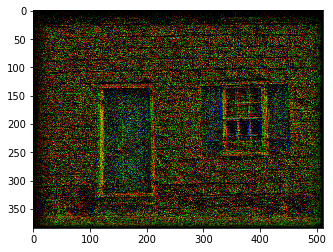

In [0]:
# Visualize the adversarial noise
diff_im = dist_tensor.numpy()[0] - im[0][0]
#diff_im = test_im - im[0][0]
print(np.mean(np.abs(diff_im)))
plt.imshow(10 * diff_im / 255.0)

In [0]:
# Train the generator using the random patches metric
l = np.float32(5)
ref_tensor = tf.convert_to_tensor(ref_images)
for j in range(15):
  for i in range(20000):
    if i % 500 == 0:
      print("Iteration: " + str(i))
      predictions = generator(tf.convert_to_tensor(ref_images, tf.float32))
      in_list = []
      in_list_ref = []
      for j in range(64):
        ul1 = np.random.randint(384-32)
        ul2 = np.random.randint(512-32)
        new_in = predictions[:, ul1:ul1+32, ul2:ul2+32, :]
        in_list.append(new_in)
        new_in_ref = ref_tensor[:, ul1:ul1+32, ul2:ul2+32, :]
        in_list_ref.append(new_in_ref)
      input_tensor = tf.stack(in_list, 1)
      input_tensor_ref = tf.stack(in_list_ref, 1)

      scores_output = wadiqam_r_0([tf.cast(input_tensor, tf.float32), tf.cast(input_tensor_ref, tf.float32)])
      print(l * tf.cast(generator_loss(ref_images, predictions), tf.float32) - tf.cast(tf.math.reduce_mean(scores_output), tf.float32))
      #print(generator_loss(predictions, ref_images))
    gen_train_step_r(wadiqam_r_0, l)
    #gen_train_step_error()
  generator.save("/content/gdrive/My Drive/Colab Notebooks/gen_q_l=5.h5")

predictions = generator(tf.convert_to_tensor(ref_images, tf.float32))

Iteration: 0
tf.Tensor(75468.03, shape=(), dtype=float32)
Iteration: 500
tf.Tensor(5249.185, shape=(), dtype=float32)


KeyboardInterrupt: ignored

In [0]:
generator = make_generator()
#generator = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/generator_adv_l=5.h5")
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
generator_loss = tf.keras.losses.MeanSquaredError()

**The following sections contain tests that are either not finished or inconclusive, nothing important is found after this point**

# Saving images and testing
Does not contain important code

In [0]:
gens = [
           "generator_mse",
           "generator_wadiqam_r_l=0.01",
           "generator_wadiqam_r_l=0.1",
           "generator_wadiqam_r_l=1",
           "generator_wadiqam_r_l=5",
           "generator_wadiqam_r_1adv_l=0.01",
           "generator_wadiqam_r_1adv_l=0.1",
           "generator_wadiqam_r_1adv_l=1",
           "generator_wadiqam_r_1adv_l=5",
           #"generator_wadiqam_r_2adv_l=0.01",
           #"generator_wadiqam_r_2adv_l=0.1",
           #"generator_wadiqam_r_2adv_l=1",
           "generator_wadiqam_r_2adv_l=5"
           ]
for gen_name in gens:
  generator = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/" + gen_name + ".h5")
  predictions = generator(tf.convert_to_tensor(ref_images, tf.float32))
  try:
    os.mkdir("/content/gdrive/My Drive/Colab Notebooks/Images" + gen_name[9:])
    print("Dir created")
  except FileExistsError:
    print("Dir exists")
  for i in range(25):
    plt.imsave("/content/gdrive/My Drive/Colab Notebooks/Images" + gen_name[9:] + "/img" + str(i) + ".png", np.clip(np.array(predictions[i]), 0, 255).astype(np.uint8) / 255.0)

Dir exists
Dir exists
Dir exists
Dir exists
Dir exists
Dir exists
Dir exists
Dir exists
Dir exists
Dir exists


In [0]:
testGen = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/generator_wadiqam_r_l=1.h5")

In [0]:
testIm = plt.imread("/content/gdrive/My Drive/HD_images/References/00003_TE_4000x3000.png")
testIm = np.reshape(testIm[:,:,:3] * 255, (1,testIm.shape[0], testIm.shape[1], 3))

In [0]:
testRes = np.clip(testGen(tf.convert_to_tensor(testIm, tf.float32)).numpy(), 0, 255).astype(np.uint8)

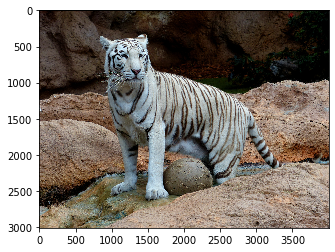

In [0]:
plt.imshow(testRes[0])
plt.imsave("/content/gdrive/My Drive/testImWDQ.png", testRes[0])

In [0]:
generator = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/generator_wadiqam_r_l=1.h5")

In [0]:
testImMSE = plt.imread("/content/gdrive/My Drive/Colab Notebooks/Images_mse/img24.png")
testImMSE = np.reshape(testImMSE[:,:,:3] * 255, (1,testImMSE.shape[0], testImMSE.shape[1], 3))
testImWDQ = plt.imread("/content/gdrive/My Drive/Colab Notebooks/Images_wadiqam_r_1adv_l=1/img24.png")
testImWDQ = np.reshape(testImWDQ[:,:,:3] * 255, (1,testImWDQ.shape[0], testImWDQ.shape[1], 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


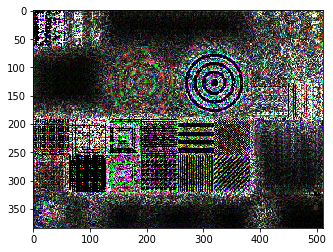

In [0]:
diff_im = np.abs((testImMSE - testImWDQ)[0])
plt.imshow(10 * diff_im / 255.0)

# MS-WADIQAM
Does not contain important code

In [0]:
def make_ms_wadiqam_model_r():
  im_input_wadiqam = tf.keras.Input(shape=(64, 32, 32 ,3), batch_size=10)
  ref_input_wadiqam = tf.keras.Input(shape=(64, 32, 32 ,3), batch_size=10)
  im_input_wadiqam_16 = tf.keras.Input(shape=(64, 16, 16 ,3), batch_size=10)
  ref_input_wadiqam_16 = tf.keras.Input(shape=(64, 16, 16 ,3), batch_size=10)

  i_conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), padding='same', activation='relu')
  i_conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same', activation='relu')
  i_conv3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same', activation='relu')
  i_conv4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2), padding='same', activation='relu')
  i_conv5 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=(2,2), padding='same', activation='relu')
  def extractor_wadiqam(image):
    conv1 = (i_conv1(image))
    conv2 = (i_conv2(conv1))
    conv3 = (i_conv3(conv2))
    conv4 = (i_conv4(conv3))
    conv5 = (i_conv5(conv4))
    return tf.reshape(conv5, (-1, 64, 512))

  i_conv1_16 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), padding='same', activation='relu')
  i_conv2_16 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same', activation='relu')
  i_conv3_16 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same', activation='relu')
  i_conv4_16 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2), padding='same', activation='relu')
  def extractor_wadiqam_16(image):
    conv1_16 = (i_conv1(image))
    conv2_16 = (i_conv2(conv1_16))
    conv3_16 = (i_conv3(conv2_16))
    conv4_16 = (i_conv4(conv3_16))
    return tf.reshape(conv4_16, (-1, 64, 256))

  patches_gen_wadiqam = tf.reshape(im_input_wadiqam, (-1, 32, 32, 3))
  patches_ref_wadiqam = tf.reshape(ref_input_wadiqam, (-1, 32, 32, 3))
  im_c_wadiqam = extractor_wadiqam(patches_gen_wadiqam)
  ref_c_wadiqam = extractor_wadiqam(patches_ref_wadiqam)
  patches_gen_wadiqam_16 = tf.reshape(im_input_wadiqam_16, (-1, 16, 16, 3))
  patches_ref_wadiqam_16 = tf.reshape(ref_input_wadiqam_16, (-1, 16, 16, 3))
  im_c_wadiqam_16 = extractor_wadiqam_16(patches_gen_wadiqam_16)
  ref_c_wadiqam_16 = extractor_wadiqam_16(patches_ref_wadiqam_16)
  im_c_wadiqam = tf.keras.layers.Concatenate(axis=2)([im_c_wadiqam, im_c_wadiqam_16])
  ref_c_wadiqam = tf.keras.layers.Concatenate(axis=2)([ref_c_wadiqam, ref_c_wadiqam_16])

  subbed_wadiqam = tf.keras.layers.Subtract()([im_c_wadiqam, ref_c_wadiqam])
  dense1_wadiqam = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(subbed_wadiqam))
  dense2_wadiqam = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(dense1_wadiqam))
  out_wadiqam = tf.keras.layers.Dense(1)(dense2_wadiqam)

  dense1_wadiqam_weights = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(subbed_wadiqam))
  dense2_wadiqam_weights = tf.keras.layers.Dropout(0.25)(tf.keras.layers.Dense(512, activation='relu')(dense1_wadiqam_weights))
  out_wadiqam_weights = tf.keras.layers.Dense(1)(dense2_wadiqam_weights)
  out_wadiqam_weights = tf.keras.layers.Lambda(lambda x: tf.math.exp(x))(out_wadiqam_weights)
  weight_sum = tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x, 1))(out_wadiqam_weights)
  weight_sum = tf.keras.layers.Lambda(lambda x: tf.math.reciprocal(x))(weight_sum)

  out_wadiqam = tf.keras.layers.Multiply()([out_wadiqam, out_wadiqam_weights])
  out_wadiqam = tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x, 1))(out_wadiqam)
  out_wadiqam = tf.keras.layers.Multiply()([out_wadiqam, weight_sum])
  out_wadiqam = tf.keras.layers.Lambda(lambda x: tf.math.multiply(np.float32(9), tf.math.sigmoid(x)))(out_wadiqam)

  toy_model_wadiqam = tf.keras.Model(inputs=[im_input_wadiqam, ref_input_wadiqam, im_input_wadiqam_16, ref_input_wadiqam_16], outputs=out_wadiqam)
  toy_model_wadiqam.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.MeanAbsoluteError())
  return toy_model_wadiqam

In [0]:
ms_wadiqam_model = make_ms_wadiqam_model_r()

In [0]:
for i in range(100):
  ms_wadiqam_model.fit_generator(adversarial.create_fr_image_batch_ms(ref_images, np.array(range(25)), scores,
                    image_names, True, decode=False, n_images=10, n_patches=64),
                   steps_per_epoch=30, epochs=5)
  ms_wadiqam_model.save("/content/gdrive/My Drive/Colab Notebooks/metric_wadiqam_ms.h5")

Epoch 1/5
30/30 [==============================] - 59s 2s/step - loss: 1.1028
Epoch 2/5
30/30 [==============================] - 58s 2s/step - loss: 0.9993
Epoch 3/5
30/30 [==============================] - 65s 2s/step - loss: 0.9127
Epoch 4/5
30/30 [==============================] - 49s 2s/step - loss: 0.9084
Epoch 5/5
30/30 [==============================] - 46s 2s/step - loss: 0.9741
Epoch 1/5
30/30 [==============================] - 37s 1s/step - loss: 0.8474
Epoch 2/5
30/30 [==============================] - 41s 1s/step - loss: 0.8399
Epoch 3/5
30/30 [==============================] - 39s 1s/step - loss: 0.8434
Epoch 4/5
30/30 [==============================] - 36s 1s/step - loss: 0.7614
Epoch 5/5
30/30 [==============================] - 42s 1s/step - loss: 0.7617
Epoch 1/5
30/30 [==============================] - 29s 966ms/step - loss: 0.7179
Epoch 2/5
30/30 [==============================] - 30s 1s/step - loss: 0.7485
Epoch 3/5
30/30 [==============================] - 26s 865ms/

In [0]:
l = np.float32(5)
ref_tensor = tf.convert_to_tensor(ref_images)
for j in range(5): #15
  for i in range(1000): #20000
    if i % 500 == 0:
      print("Iteration: " + str(i))
      predictions = generator(tf.convert_to_tensor(ref_images, tf.float32))
      in_list = []
      in_list_ref = []
      for j in range(64):
        ul1 = np.random.randint(384-32)
        ul2 = np.random.randint(512-32)
        new_in = predictions[:, ul1:ul1+32, ul2:ul2+32, :]
        in_list.append(new_in)
        new_in_ref = ref_tensor[:, ul1:ul1+32, ul2:ul2+32, :]
        in_list_ref.append(new_in_ref)
      input_tensor = tf.stack(in_list, 1)
      input_tensor_ref = tf.stack(in_list_ref, 1)

      scores_output = wadiqam_r_1([tf.cast(input_tensor, tf.float32), tf.cast(input_tensor_ref, tf.float32)])
      print(l * tf.cast(generator_loss(ref_images, predictions), tf.float32) - tf.cast(tf.math.reduce_mean(scores_output), tf.float32))
      #print(generator_loss(predictions, ref_images))
    gen_train_step_r(wadiqam_r_1, l)
    #gen_train_step_error()
  generator.save("/content/gdrive/My Drive/Colab Notebooks/qgen_wr_l=5.h5")

predictions = generator(tf.convert_to_tensor(ref_images, tf.float32))

Iteration: 0
tf.Tensor(75499.164, shape=(), dtype=float32)
Iteration: 500
tf.Tensor(4744.551, shape=(), dtype=float32)
Iteration: 0
tf.Tensor(3477.535, shape=(), dtype=float32)
Iteration: 500
tf.Tensor(3011.1233, shape=(), dtype=float32)
Iteration: 0
tf.Tensor(2697.2874, shape=(), dtype=float32)
Iteration: 500
tf.Tensor(2431.5305, shape=(), dtype=float32)
Iteration: 0
tf.Tensor(2322.348, shape=(), dtype=float32)
Iteration: 500
tf.Tensor(2239.2434, shape=(), dtype=float32)
Iteration: 0
tf.Tensor(2175.1785, shape=(), dtype=float32)
Iteration: 500
tf.Tensor(2116.709, shape=(), dtype=float32)


In [0]:
enc = generators[1](tf.convert_to_tensor(ref_images, tf.float32))

In [0]:
dec = generators[2](enc)
q_enc = tf.math.rint(enc)
q_dec = generators[2](q_enc)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


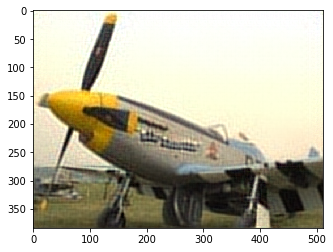

In [0]:
plt.imshow(dec[19].numpy().astype(int))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


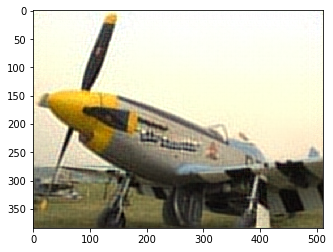

In [0]:
plt.imshow(q_dec[19].numpy().astype(int))

In [0]:
q_enc[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


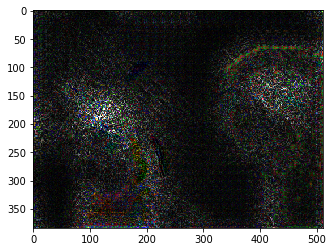

In [0]:
test1 = (plt.imread("/content/gdrive/My Drive/Colab Notebooks/Images_mse/img22.png") * 255).astype(int)[:,:,:3]
test2 = (plt.imread("/content/gdrive/My Drive/Colab Notebooks/Images_wadiqam_l=0.1/img22.png") * 255).astype(int)[:,:,:3]

plt.imshow(7*(np.clip(np.abs(test1-test2).astype(int), 0, 255)[:,:,:3]))

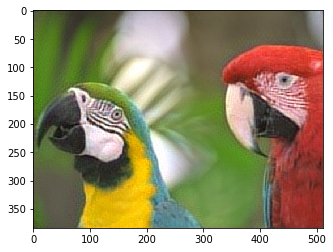

In [0]:
plt.imshow(test1[:,:,:3])

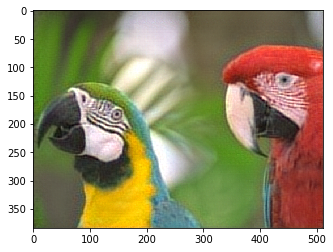

In [0]:
plt.imshow(test2[:,:,:3])